<a href="https://colab.research.google.com/github/manishmcsa/S11/blob/main/S11_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/S11"

/content/drive/MyDrive/S11


In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

from data_engine import DataEngine
from config import ModelConfig
from s11_resnet import ResNetCifar10
from train import train
from test import test
from results import plot_images, plot_graph
from utils import *
from visualize import VisualizeCam
from lr_range_test import LRRangeFinder
from lr_cycle_plot import LRCyclePlot

  pip install torch-lr-finder -v --global-option="amp"


In [4]:
# View model config
args = ModelConfig()
args.print_config()
print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 512,
  'dropout': 0,
  'epochs': 24,
  'l1_decay': 2e-06,
  'l2_decay': 0.0006,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}

CUDA Available


Files already downloaded and verified
Files already downloaded and verified
 deer   car horse   dog


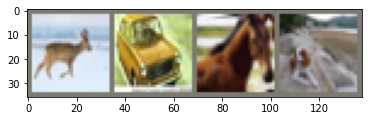

In [5]:
data = DataEngine(args)

# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))

In [6]:
device = which_device()
model =ResNetCifar10().to(device)
show_model_summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
        LayerBlock-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,456
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
       BasicBlock-13          [-1, 128, 16, 16]               0
       LayerBlock-14          [-1, 128,


Learning rate search finished. See the graph with {finder_name}.plot()


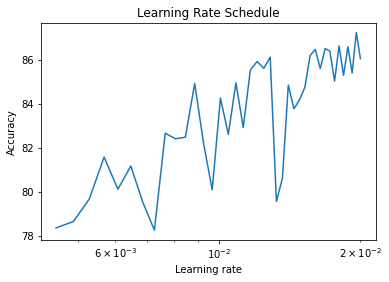

In [7]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
lr_finder = LRRangeFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(data.train_loader, val_loader=data.test_loader, start_lr=1e-4, end_lr=0.02,
                     epochs=50, step_mode="linear")
lr_finder.plot(metric='acc', skip_start=10, skip_end=0)
lr_finder.reset()

In [8]:
best_acc = lr_finder.best_acc
best_lr = lr_finder.history["lr"][lr_finder.history["acc"].index(best_acc)]
print("Best Accuracy: %s\nBest Learning Rate: %s" % (best_acc, best_lr))

Best Accuracy: 87.24
Best Learning Rate: 0.019606061224489796


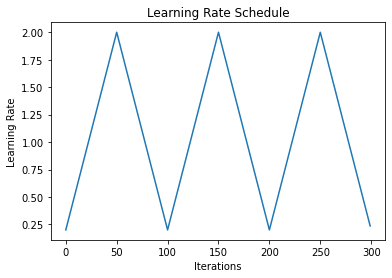

<Figure size 432x288 with 0 Axes>

In [9]:
lrplt = LRCyclePlot({})
lrplt("lr_cycle_plot_test.png")

In [11]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
scheduler = OneCycleLR(optimizer, max_lr=best_lr, steps_per_epoch=len(data.train_loader),
                       epochs=args.epochs, div_factor=8, final_div_factor=1,
                       pct_start=5/args.epochs, anneal_strategy="linear")

test_losses, train_losses, test_accs, train_accs = [], [], [], []
misclassified_imgs, correct_imgs = [], []
lr_trend = []
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(args.epochs):
      lr_trend.append(optimizer.param_groups[0]['lr'])
      print(f"EPOCH: {epoch+1} (LR: {lr_trend[-1]:0.6f})")
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs, scheduler)
      test(model, device, data.test_loader, criterion, data.classes, test_losses,
           test_accs, misclassified_imgs, correct_imgs, epoch==args.epochs-1)

# train and test the model
run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 (LR: 0.002451)


L2_loss=283.48095703125 L1_loss=74323.2265625 Loss=0.3633814752101898 Batch_id=97 Accuracy=98.44: 100%|██████████| 98/98 [00:15<00:00,  6.47it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0009, Accuracy: 8858/10000 (88.58%)

EPOCH: 2 (LR: 0.005889)


L2_loss=283.39874267578125 L1_loss=74236.734375 Loss=0.38093405961990356 Batch_id=97 Accuracy=98.19: 100%|██████████| 98/98 [00:15<00:00,  6.47it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0009, Accuracy: 8764/10000 (87.64%)

EPOCH: 3 (LR: 0.009327)


L2_loss=283.4051818847656 L1_loss=74190.1796875 Loss=0.3709890842437744 Batch_id=97 Accuracy=97.46: 100%|██████████| 98/98 [00:15<00:00,  6.46it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0012, Accuracy: 8601/10000 (86.01%)

EPOCH: 4 (LR: 0.012765)


L2_loss=283.5650634765625 L1_loss=74218.25 Loss=0.5129735469818115 Batch_id=97 Accuracy=96.58: 100%|██████████| 98/98 [00:15<00:00,  6.44it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0011, Accuracy: 8672/10000 (86.72%)

EPOCH: 5 (LR: 0.016203)


L2_loss=283.8663330078125 L1_loss=74310.2109375 Loss=0.4690045118331909 Batch_id=97 Accuracy=95.97: 100%|██████████| 98/98 [00:15<00:00,  6.48it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0011, Accuracy: 8632/10000 (86.32%)

EPOCH: 6 (LR: 0.019597)


L2_loss=284.1734619140625 L1_loss=74414.1015625 Loss=0.476077675819397 Batch_id=97 Accuracy=95.75: 100%|██████████| 98/98 [00:15<00:00,  6.47it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0011, Accuracy: 8619/10000 (86.19%)

EPOCH: 7 (LR: 0.018694)


L2_loss=284.3641357421875 L1_loss=74459.1796875 Loss=0.3930060863494873 Batch_id=97 Accuracy=96.39: 100%|██████████| 98/98 [00:15<00:00,  6.49it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0012, Accuracy: 8568/10000 (85.68%)

EPOCH: 8 (LR: 0.017791)


L2_loss=284.49945068359375 L1_loss=74485.421875 Loss=0.4225405752658844 Batch_id=97 Accuracy=96.80: 100%|██████████| 98/98 [00:15<00:00,  6.47it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0012, Accuracy: 8636/10000 (86.36%)

EPOCH: 9 (LR: 0.016888)


L2_loss=284.5946960449219 L1_loss=74499.7734375 Loss=0.39632683992385864 Batch_id=97 Accuracy=96.99: 100%|██████████| 98/98 [00:15<00:00,  6.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0012, Accuracy: 8652/10000 (86.52%)

EPOCH: 10 (LR: 0.015985)


L2_loss=284.6126708984375 L1_loss=74468.25 Loss=0.40950286388397217 Batch_id=97 Accuracy=97.42: 100%|██████████| 98/98 [00:15<00:00,  6.43it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0010, Accuracy: 8755/10000 (87.55%)

EPOCH: 11 (LR: 0.015082)


L2_loss=284.582763671875 L1_loss=74417.09375 Loss=0.3768673837184906 Batch_id=97 Accuracy=97.77: 100%|██████████| 98/98 [00:15<00:00,  6.41it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0010, Accuracy: 8764/10000 (87.64%)

EPOCH: 12 (LR: 0.014179)


L2_loss=284.5487976074219 L1_loss=74363.15625 Loss=0.4001634418964386 Batch_id=97 Accuracy=97.81: 100%|██████████| 98/98 [00:15<00:00,  6.48it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0010, Accuracy: 8841/10000 (88.41%)

EPOCH: 13 (LR: 0.013276)


L2_loss=284.46746826171875 L1_loss=74288.2578125 Loss=0.38701120018959045 Batch_id=97 Accuracy=98.22: 100%|██████████| 98/98 [00:15<00:00,  6.44it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0010, Accuracy: 8827/10000 (88.27%)

EPOCH: 14 (LR: 0.012374)


L2_loss=284.4027404785156 L1_loss=74217.1328125 Loss=0.4314393401145935 Batch_id=97 Accuracy=98.13: 100%|██████████| 98/98 [00:15<00:00,  6.43it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0012, Accuracy: 8757/10000 (87.57%)

EPOCH: 15 (LR: 0.011471)


L2_loss=284.2942810058594 L1_loss=74131.6953125 Loss=0.3983178734779358 Batch_id=97 Accuracy=98.46: 100%|██████████| 98/98 [00:15<00:00,  6.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0010, Accuracy: 8872/10000 (88.72%)

EPOCH: 16 (LR: 0.010568)


L2_loss=284.16082763671875 L1_loss=74031.0546875 Loss=0.3293588161468506 Batch_id=97 Accuracy=98.66: 100%|██████████| 98/98 [00:15<00:00,  6.41it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0009, Accuracy: 8896/10000 (88.96%)

EPOCH: 17 (LR: 0.009665)


L2_loss=284.02691650390625 L1_loss=73931.390625 Loss=0.3806895613670349 Batch_id=97 Accuracy=98.62: 100%|██████████| 98/98 [00:15<00:00,  6.43it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0010, Accuracy: 8795/10000 (87.95%)

EPOCH: 18 (LR: 0.008762)


L2_loss=283.88409423828125 L1_loss=73827.4375 Loss=0.39752647280693054 Batch_id=97 Accuracy=98.78: 100%|██████████| 98/98 [00:15<00:00,  6.47it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0011, Accuracy: 8791/10000 (87.91%)

EPOCH: 19 (LR: 0.007859)


L2_loss=283.71954345703125 L1_loss=73713.8671875 Loss=0.3564339280128479 Batch_id=97 Accuracy=99.02: 100%|██████████| 98/98 [00:15<00:00,  6.46it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0010, Accuracy: 8915/10000 (89.15%)

EPOCH: 20 (LR: 0.006956)


L2_loss=283.5563049316406 L1_loss=73604.8828125 Loss=0.34683677554130554 Batch_id=97 Accuracy=99.02: 100%|██████████| 98/98 [00:15<00:00,  6.43it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0009, Accuracy: 8958/10000 (89.58%)

EPOCH: 21 (LR: 0.006053)


L2_loss=283.38824462890625 L1_loss=73495.65625 Loss=0.33767443895339966 Batch_id=97 Accuracy=99.17: 100%|██████████| 98/98 [00:15<00:00,  6.46it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0009, Accuracy: 8985/10000 (89.85%)

EPOCH: 22 (LR: 0.005150)


L2_loss=283.2273254394531 L1_loss=73388.515625 Loss=0.3372933268547058 Batch_id=97 Accuracy=99.33: 100%|██████████| 98/98 [00:15<00:00,  6.43it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0009, Accuracy: 8998/10000 (89.98%)

EPOCH: 23 (LR: 0.004247)


L2_loss=283.071533203125 L1_loss=73290.2734375 Loss=0.3226010203361511 Batch_id=97 Accuracy=99.41: 100%|██████████| 98/98 [00:15<00:00,  6.44it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 85 %
Accuracy of  deer : 87 %
Accuracy of   dog : 75 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 84 %

Test set: Average loss: 0.0009, Accuracy: 9009/10000 (90.09%)

EPOCH: 24 (LR: 0.003344)


L2_loss=282.93231201171875 L1_loss=73200.6328125 Loss=0.33322083950042725 Batch_id=97 Accuracy=99.53: 100%|██████████| 98/98 [00:15<00:00,  6.45it/s]



Accuracy of plane : 85 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 87 %
Accuracy of  deer : 83 %
Accuracy of   dog : 83 %
Accuracy of  frog : 100 %
Accuracy of horse : 90 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0008, Accuracy: 9049/10000 (90.49%)



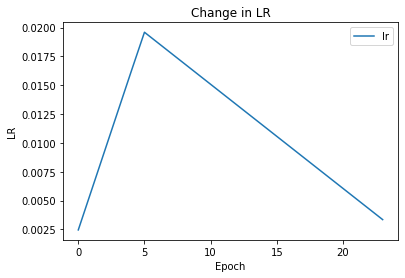

In [12]:
plt_data = {
    "lr": lr_trend,
}
plot_graph(plt_data, "LR")

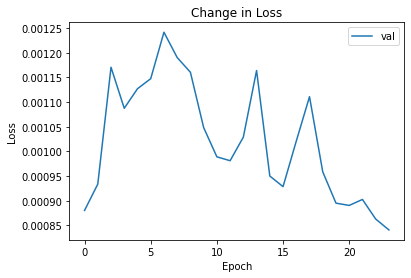

In [13]:
plt_data = {
    "val": test_losses,
}
plot_graph(plt_data, "Loss")

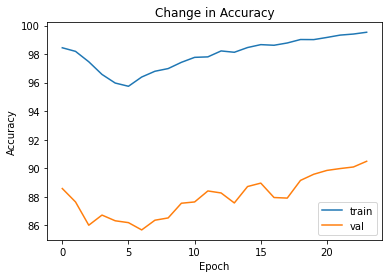

In [14]:
plt_data = {
    "train": train_accs,
    "val": test_accs
}
plot_graph(plt_data, "Accuracy")

In [15]:
target_layers = ["layer0", "layer1", "layer2", "layer3"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

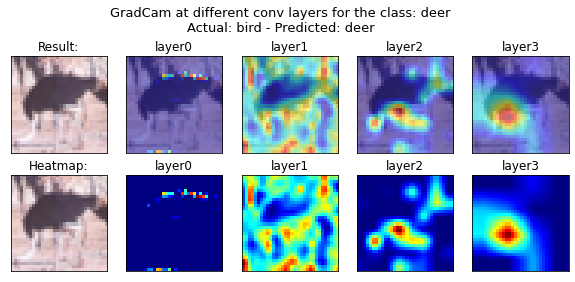

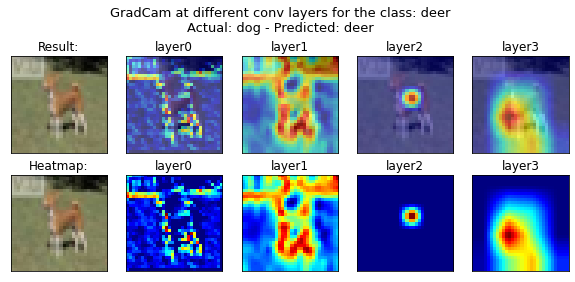

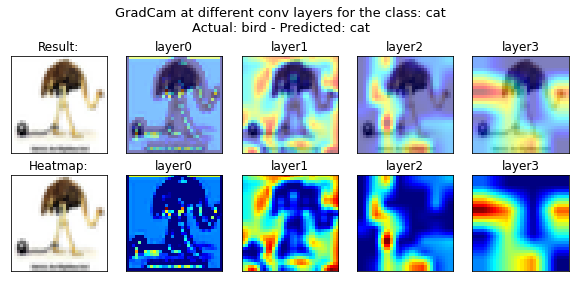

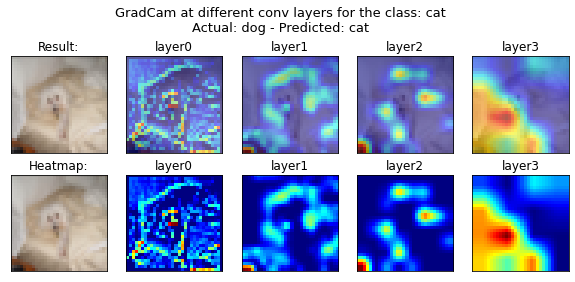

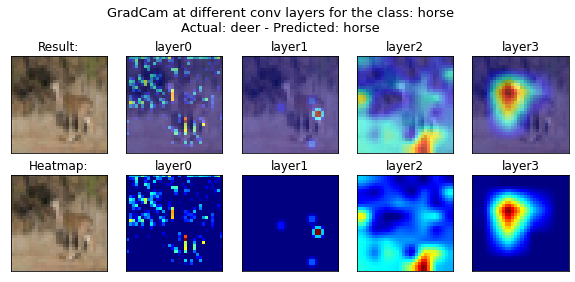

In [16]:
num_img = 5
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect")